In [1]:
import numpy as np
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow import keras
from tensorflow.keras import layers

# 一 eager模式下运算

In [2]:
# 在eager模式下可以直接进行运算
x = [[3.]]
m = tf.matmul(x, x)
print(m.numpy())

[[9.]]


In [3]:
a = tf.constant([[1,9],[3,6]])
print(a)

tf.Tensor(
[[1 9]
 [3 6]], shape=(2, 2), dtype=int32)


In [4]:
b = tf.add(a, 2)
print(b)
print(a*b)

tf.Tensor(
[[ 3 11]
 [ 5  8]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 3 99]
 [15 48]], shape=(2, 2), dtype=int32)


In [5]:
s = np.multiply(a,b)
print(s)

[[ 3 99]
 [15 48]]


# 二 动态控制流

In [6]:
def fizzbuzz(max_num):
    counter = tf.constant(0)
    max_num = tf.convert_to_tensor(max_num)
    for num in range(1, max_num.numpy()+1):
        num = tf.constant(num)
        if int(num % 3) == 0 and int(num % 5) == 0:
            print('FizzBuzz')
        elif int(num % 3) == 0:
            print('Fizz')
        elif int(num % 5) == 0:
            print('Buzz')
        else:
            print(num.numpy())
        counter += 1

In [7]:
fizzbuzz(16)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz
16


# 三 构建模型

In [8]:
# 如果必须强制执行该层，则在构造函数中设置self.dynamic = True：
class MySimpleLayer(tf.keras.layers.Layer):
    def __init__(self, output_units):
        super(MySimpleLayer, self).__init__()
        self.output_units = output_units
        self.dynamic = True

    def build(self, input_shape):
        self.kernel = self.add_variable(
        "kernel", [input_shape[-1], self.output_units])

    def call(self, input):
        return tf.matmul(input, self.kernel)
    
# 构造一个模型
class MNISTModel(tf.keras.Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=10)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):
        """Run the model."""
        result = self.dense1(inputs)
        result = self.dense2(result)
        result = self.dense2(result)  # reuse variables from dense2 layer
        return result


In [12]:
model = MNISTModel()

# 四 使用eager模式训练

In [13]:
# 计算梯度
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
    loss = w*w
grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


In [14]:
# 训练一个模型
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu', 
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])


In [15]:
for images,labels in dataset.take(1):
    print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[ 0.01089907  0.01694181 -0.02405175 -0.00179131  0.02165    -0.01183439
   0.0167188   0.00370135  0.00091849  0.00229956]]


In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []
for (batch, (images, labels)) in enumerate(dataset.take(400)):
    if batch % 10 == 0:
        print('.', end='')
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
        loss_value = loss_object(labels, logits)

    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

........................................

Text(0, 0.5, 'Loss [entropy]')

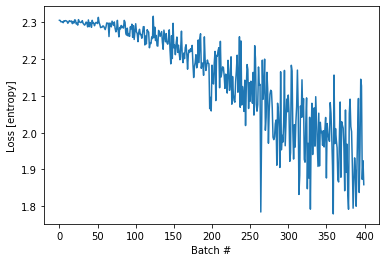

In [17]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

# 五 变量求导优化

In [18]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.W = tf.Variable(5., name='weight')
        self.B = tf.Variable(10., name='bias')
    def call(self, inputs):
        return inputs * self.W + self.B

# 构建数据集
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# 损失函数
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.W, model.B])

model = MyModel()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

# 训练
for i in range(300):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.W, model.B]))
    if i % 20 == 0:
        print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

Initial loss: 68.953
Loss at step 000: 66.269
Loss at step 020: 30.151
Loss at step 040: 14.020
Loss at step 060: 6.815
Loss at step 080: 3.597
Loss at step 100: 2.160
Loss at step 120: 1.518
Loss at step 140: 1.232
Loss at step 160: 1.104
Loss at step 180: 1.046
Loss at step 200: 1.021
Loss at step 220: 1.009
Loss at step 240: 1.004
Loss at step 260: 1.002
Loss at step 280: 1.001
Final loss: 1.001
W = 2.990825891494751, B = 2.0145161151885986


# 六 eager模式下的对象

In [19]:
# 变量即对象
if tf.test.is_gpu_available():
    with tf.device("gpu:0"):
        v = tf.Variable(tf.random.normal([1000, 1000]))
        v = None  # v no longer takes up GPU memory
# 对象保存
x = tf.Variable(6.0)
checkpoint = tf.train.Checkpoint(x=x)

x.assign(1.0)
checkpoint.save('./ckpt/')

x.assign(8.0)
checkpoint.restore(tf.train.latest_checkpoint('./ckpt/'))
print(x)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>


In [20]:
# 模型保持
import os
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = './ck_model_dir'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [21]:
# 面向对象的指标
m = tf.keras.metrics.Mean('loss')
m(0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [22]:
m(5)

<tf.Tensor: shape=(), dtype=float32, numpy=2.5>

In [23]:
print(m.result())  # => 2.5

tf.Tensor(2.5, shape=(), dtype=float32)


In [24]:
m([8, 9])

<tf.Tensor: shape=(), dtype=float32, numpy=5.5>

In [25]:
print(m.result())  # => 5.5

tf.Tensor(5.5, shape=(), dtype=float32)


# 七 高级自动化主题

In [27]:
# 动态模型
def line_search_step(fn, init_x, rate=1.0):
    with tf.GradientTape() as tape:
        # tensor必须手动watch
        tape.watch(init_x)
        value = fn(init_x)
    grad = tape.gradient(value, init_x)
    grad_norm = tf.reduce_sum(grad * grad)
    init_value = value
    while value > init_value - rate * grad_norm:
        x = init_x - rate * grad
        value = fn(x)
        rate /= 2.0
    return x, value

# 自定义梯度
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
    y = tf.identity(x)
    def grad_fn(dresult):
        return [tf.clip_by_norm(dresult, norm), None]
    return y, grad_fn

# 自定义梯度可以提供数值稳定的梯度
def log1pexp(x):
    return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1pexp(x)
    return tape.gradient(value, x)


In [28]:
print(grad_log1pexp(tf.constant(0.)).numpy())

0.5


In [29]:
# However, x = 100 fails because of numerical instability.
print(grad_log1pexp(tf.constant(100.)).numpy())

nan


这里，log1pexp函数可以使用自定义梯度求导进行分析简化。 下面的实现重用了在前向传递期间计算的tf.exp（x）的值 - 通过消除冗余计算使其更有效：

In [30]:
@tf.custom_gradient
def log1pexp(x):
    e = tf.exp(x)
    def grad(dy):
        return dy * (1 - 1 / (1 + e))
    return tf.math.log(1 + e), grad

def grad_log1pexp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1pexp(x)
    return tape.gradient(value, x)

In [31]:
print(grad_log1pexp(tf.constant(0.)).numpy())

0.5


In [32]:
print(grad_log1pexp(tf.constant(100.)).numpy())

1.0
